<a href="https://colab.research.google.com/github/aueskinj/Data-Science-Projects/blob/main/Effect_of_government_social_programs_on_poverty_in_Kenya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import grangercausalitytests

In [ ]:
data = pd.read_csv('/content/Final_data.csv')

In [ ]:
df = pd.DataFrame(data)

In [ ]:
print(df.columns)

Index(['Year', 'GDP', 'Inflation', 'ExchangeRate', 'QuantitySold'], dtype='object')


In [ ]:
df2 = []

In [ ]:
df['year'] = pd.to_datetime(df['Year'], format='%Y').dt.to_period('Y')
df["GDP"] = pd.to_numeric(df["GDP"])
df["ir"] = pd.to_numeric(df["Inflation"])
df["er"] = pd.to_numeric(df["ExchangeRate"])
df["qty"] = pd.to_numeric(df["QuantitySold"])

In [ ]:
df

,Year,GDP,Inflation,ExchangeRate,QuantitySold,year,ir,er,qty
0,2022,3.797848,7.637500,117.865989,5924.8,2022,7.637500,117.865989,5924.8
1,2021,5.020111,6.110833,109.637747,6409.3,2021,6.110833,109.637747,6409.3
2,2020,4.967721,5.285833,106.450780,5723.0,2020,5.285833,106.450780,5723.0
3,2019,4.213517,5.228462,101.991298,6425.4,2019,5.228462,101.991298,6425.4
4,2018,3.837958,4.695000,101.301574,6101.8,2018,4.695000,101.301574,6101.8
5,2017,5.647946,8.018333,103.410004,6334.0,2017,8.018333,103.410004,6334.0
6,2016,5.114159,6.303333,101.504369,5978.3,2016,6.303333,101.504369,5978.3
7,2015,-0.272766,6.575833,98.178453,5470.1,2015,6.575833,98.178453,5470.1
8,2014,7.590489,6.884167,87.922164,5377.3,2014,6.884167,87.922164,5377.3
9,2013,4.846635,5.715833,86.122879,4173.5,2013,5.715833,86.122879,4173.5


In [ ]:
columns = ['Year','Inflation', 'ExchangeRate', 'QuantitySold']

In [ ]:
df.drop(columns, axis=1, inplace=True)

In [ ]:
new_df = df.set_index('year')

In [ ]:
new_df

,GDP,ir,er,qty
year,,,,
2022,3.797848,7.637500,117.865989,5924.8
2021,5.020111,6.110833,109.637747,6409.3
2020,4.967721,5.285833,106.450780,5723.0
2019,4.213517,5.228462,101.991298,6425.4
2018,3.837958,4.695000,101.301574,6101.8
2017,5.647946,8.018333,103.410004,6334.0
2016,5.114159,6.303333,101.504369,5978.3
2015,-0.272766,6.575833,98.178453,5470.1
2014,7.590489,6.884167,87.922164,5377.3


# Decriptive Analytics

In [ ]:
def Describe(x):
  # Display basic descriptive statistics
  desc_stats = df.describe()
  #data distribution
  skewness = df.skew()
  kurtosis = df.kurt()

  # Display additional statistics, e.g., median and interquartile range (IQR)
  median = df.median()
  iqr = df.quantile(0.75) - df.quantile(0.25)

  result = pd.concat([desc_stats, skewness, kurtosis, median, iqr], keys=['Descriptive Stats', 'Skewness', 'Kurtosis', 'Median', 'IQR'])

  print(result)

  # Plotting a histogram
  plt.figure(figsize=(8, 6))
  sns.histplot(df[column], kde=True, color='blue')
  plt.title(f'Histogram of {column}')
  plt.xlabel(column)
  plt.ylabel('Frequency')
  plt.show()

In [ ]:
descriptive = df.describe()

In [ ]:
descriptive.to_csv("descriptive")

In [ ]:
df.skew()

<ipython-input-15-9e0b1e29546f>:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.skew()


GDP   -1.327103
ir     0.313970
er    -0.163901
qty   -1.636242
dtype: float64

In [ ]:
df.kurt(0)

<ipython-input-16-3c16f4afdef4>:1: FutureWarning: The default value of numeric_only in DataFrame.kurt is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.kurt(0)


GDP    4.084450
ir    -0.713232
er     0.326049
qty    3.249880
dtype: float64

## Correlation

In [ ]:
corr_matrix = df.corr()
corr_matrix.to_csv('correlation_matrix.csv', index=True)

<ipython-input-17-ca1699254104>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


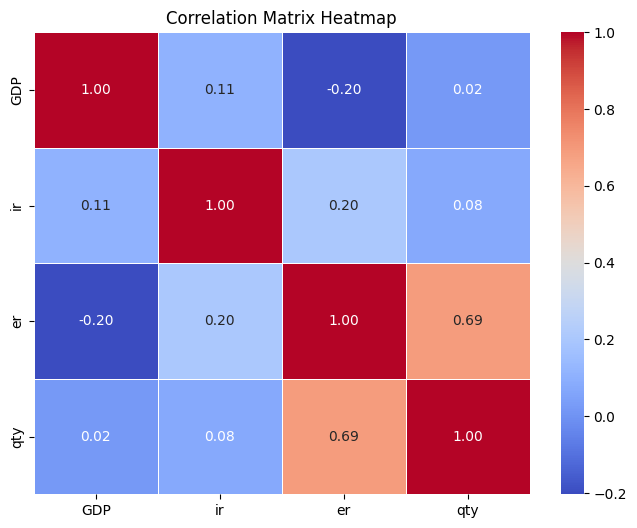

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

## Granger Causality Test

In [ ]:
def granger_causation_matrix(data, variables, p, test = 'ssr_chi2test', verbose=False):
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [ ]:
df.columns

Index(['GDP', 'year', 'ir', 'er', 'qty'], dtype='object')

## Regression Analysis

In [ ]:
X = df[['er', 'GDP']]
y = df['qty']

# Fit the model
model = sm.OLS(y, X).fit()

#save regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    qty   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              665.5
Date:                Thu, 14 Mar 2024   Prob (F-statistic):                    1.27e-09
Time:                        14:56:22   Log-Likelihood:                         -75.291
No. Observations:                  10   AIC:                                      154.6
Df Residuals:                       8   BIC:                                      155.2
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


`Saving TO txt file`

### ANOVA model

In [ ]:
from statsmodels.formula.api import ols

# Assuming df is your DataFrame
model = ols('qty ~ er+ir+GDP', data=df).fit()

# Perform ANOVA
anova_result = sm.stats.anova_lm(model)
print(anova_result)


           df        sum_sq       mean_sq         F    PR(>F)
er        1.0  1.987074e+06  1.987074e+06  5.992694  0.049926
ir        1.0  1.832674e+04  1.832674e+04  0.055270  0.821952
GDP       1.0  1.293402e+05  1.293402e+05  0.390069  0.555253
Residual  6.0  1.989496e+06  3.315827e+05       NaN       NaN


In [ ]:
anova_result.to_csv('anova.csv', index=True)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

vif_results = calculate_vif(X)

In [ ]:
vif_results

,Variable,VIF
0,er,5.876632
1,GDP,5.876632


In [ ]:
def reg_analysis(y, x):
  model = sm.OLS(y, x).fit()
  print(model.summary())

  y_pred = model.predict(x)
  plt.plot(x, y_pred, label='Line Plot')
  plt.scatter(x, y, color='red', label='Scatter Plot')
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.title('line Plot vs Scatter plot')

  # Add a legend
  plt.legend()

  # Show the plot
  plt.show()


## Inflation Rate

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                                 OLS Regression Results                                
Dep. Variable:                    qty   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.961
Method:                 Least Squares   F-statistic:                              249.7
Date:                Thu, 14 Mar 2024   Prob (F-statistic):                    7.17e-08
Time:                        14:55:49   Log-Likelihood:                         -84.101
No. Observations:                  10   AIC:                                      170.2
Df Residuals:                       9   BIC:                                      170.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

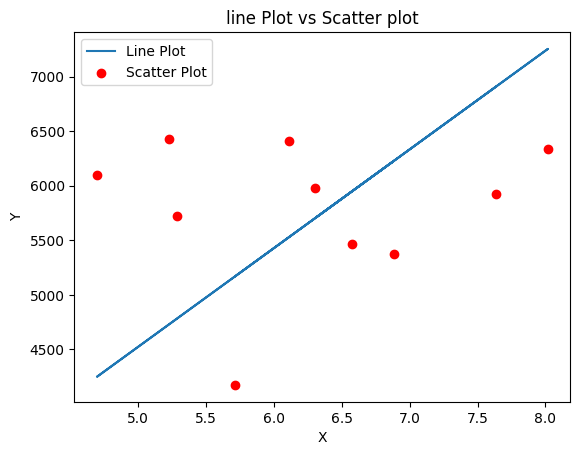

In [ ]:
reg_analysis(y, df['ir'])

## Exchange Rate

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                                 OLS Regression Results                                
Dep. Variable:                    qty   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              1395.
Date:                Thu, 14 Mar 2024   Prob (F-statistic):                    3.51e-11
Time:                        14:55:50   Log-Likelihood:                         -75.643
No. Observations:                  10   AIC:                                      153.3
Df Residuals:                       9   BIC:                                      153.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

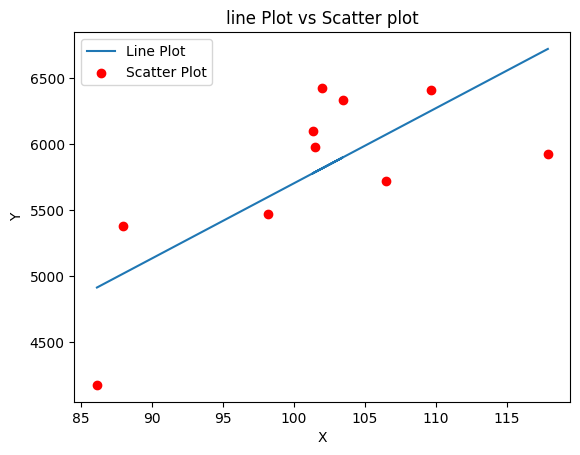

In [ ]:
reg_analysis(y, df['er'])

## GDP

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                                 OLS Regression Results                                
Dep. Variable:                    qty   R-squared (uncentered):                   0.840
Model:                            OLS   Adj. R-squared (uncentered):              0.822
Method:                 Least Squares   F-statistic:                              47.33
Date:                Thu, 14 Mar 2024   Prob (F-statistic):                    7.23e-05
Time:                        14:55:50   Log-Likelihood:                         -91.723
No. Observations:                  10   AIC:                                      185.4
Df Residuals:                       9   BIC:                                      185.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

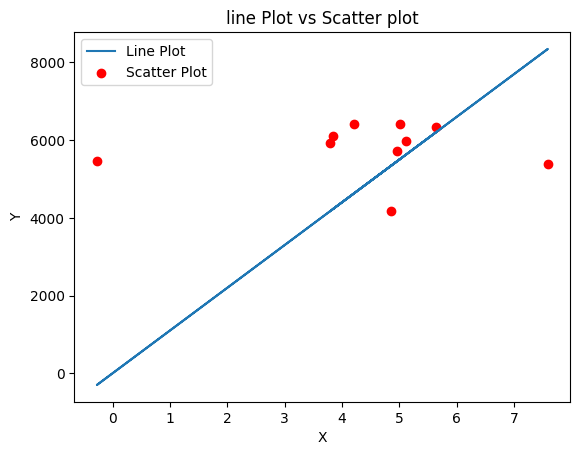

In [ ]:
reg_analysis(y, df['GDP'])

## Transformed

In [ ]:
data['GDP_centered'] = data['GDP'] - data['GDP'].mean()

In [ ]:
data.columns

Index(['Year', 'GDP', 'Inflation', 'ExchangeRate', 'QuantitySold', 'year',
       'ir', 'er', 'qty', 'GDP_centered'],
      dtype='object')

In [ ]:
data['GDP_log'] = np.log(data['GDP'])
data['ir_log'] = np.log(data['ir'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
data.fillna(0, inplace=True)

In [ ]:
data

,Year,GDP,Inflation,ExchangeRate,QuantitySold,year,ir,er,qty,GDP_centered,GDP_log,ir_log
0,2022,3.797848,7.637500,117.865989,5924.8,2022,7.637500,117.865989,5924.8,-0.678514,1.334435,2.033070
1,2021,5.020111,6.110833,109.637747,6409.3,2021,6.110833,109.637747,6409.3,0.543749,1.613452,1.810063
2,2020,4.967721,5.285833,106.450780,5723.0,2020,5.285833,106.450780,5723.0,0.491359,1.602961,1.665030
3,2019,4.213517,5.228462,101.991298,6425.4,2019,5.228462,101.991298,6425.4,-0.262845,1.438298,1.654117
4,2018,3.837958,4.695000,101.301574,6101.8,2018,4.695000,101.301574,6101.8,-0.638404,1.344940,1.546498
5,2017,5.647946,8.018333,103.410004,6334.0,2017,8.018333,103.410004,6334.0,1.171585,1.731292,2.081731
6,2016,5.114159,6.303333,101.504369,5978.3,2016,6.303333,101.504369,5978.3,0.637797,1.632013,1.841079
7,2015,-0.272766,6.575833,98.178453,5470.1,2015,6.575833,98.178453,5470.1,-4.749128,0.000000,1.883401
8,2014,7.590489,6.884167,87.922164,5377.3,2014,6.884167,87.922164,5377.3,3.114128,2.026896,1.929224
9,2013,4.846635,5.715833,86.122879,4173.5,2013,5.715833,86.122879,4173.5,0.370273,1.578285,1.743240


In [ ]:
X = sm.add_constant(data[['ir_log', 'er', 'GDP_log']])
y = df['qty']

# Fit the model
model = sm.OLS(y, X).fit()

#save regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     2.068
Date:                Thu, 14 Mar 2024   Prob (F-statistic):              0.206
Time:                        14:55:51   Log-Likelihood:                -75.288
No. Observations:                  10   AIC:                             158.6
Df Residuals:                       6   BIC:                             159.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        884.1776   2786.083      0.317      0.7

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
